In [2]:
# Import libraries
import psutil
import pandas as pd
import numpy as np
from fuzzywuzzy import process, fuzz
import glob
import time
import boto3
import os
from datetime import date
from textblob import TextBlob

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

### Load cleaned data

In [3]:
psutil.virtual_memory()

svmem(total=8461193216, available=2753904640, percent=67.5, used=5707288576, free=2753904640)

In [ ]:
# Read in commentors
commentors = pd.read_csv('data/cleaned/comments.csv', usecols=['commentor'])

### Resolve commentors suspected to be the same individual

In [ ]:
# number of unique commentors
commentors.commentor.nunique()

In [ ]:
# get an example of a potential single commentor under two different usernames
commentors[commentors.commentor.str.contains("All Eyez On Me")]['commentor'].unique()

In [ ]:
# get another example
commentors[commentors.commentor.str.contains("Native Americans")]['commentor'].unique()

In [ ]:
fuzz.partial_ratio('"All Eyez On Me" in theaters NOW!!!','"All Eyez On Me" in theaters june 16 2017')

In [ ]:
unique_commentors = pd.DataFrame(commentors.commentor.unique())
unique_commentors.columns = ['commentor']
unique_commentors = unique_commentors.sort_values(by=['commentor']).reset_index(drop=True)
df = unique_commentors[:1000]

In [ ]:
%%time

# Create df of unique commentor's usernames
unique_commentors = pd.DataFrame(commentors.commentor.unique())
unique_commentors.columns = ['commentor']
unique_commentors = unique_commentors.sort_values(by=['commentor']).reset_index(drop=True)

increment = 1000
for i in range(0,round(unique_commentors.shape[0]), increment):
    start_time = time.time()
    print(i)
    df = unique_commentors[i:i+increment]

    # Compare usernames to find potential split entities
    potential_matches = list()
    for name in df.commentor:
        if len(name) < 10:
            continue
        for other_name in df.commentor:
            if name != other_name and len(other_name) > 10:
                score = fuzz.partial_ratio(name, other_name)
                if score >= 83:
                    potential_matches.append([name,other_name,score])

    potential_matches_df = pd.DataFrame(potential_matches, columns=['username1','username2','score'])
    potential_matches_df.to_csv(f'tmp_entity_resolution/{i}.csv', header=False, index=False)
    print(time.time() - start_time)

In [ ]:
# Read in resolved usernames
resolved_usernames_files = glob.glob('tmp_entity_resolution/*.csv')
data = list()

for filename in resolved_usernames_files:
    df = pd.read_csv(filename, names=['commentor1','commentor2','score'])
    data.append(df)

resolved_usernames = pd.concat(data, axis=0, ignore_index=True)
resolved_usernames.shape

In [ ]:
# Calculate various ratios
resolved_usernames['ratio'] = resolved_usernames.apply(lambda x: fuzz.ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['partial_token_set_ratio'] = resolved_usernames.apply(lambda x: fuzz.partial_token_set_ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['token_sort_ratio'] = resolved_usernames.apply(lambda x: fuzz.token_sort_ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['WRatio'] = resolved_usernames.apply(lambda x: fuzz.WRatio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['avg_score'] = resolved_usernames[['score', 'ratio','partial_token_set_ratio','token_sort_ratio']].mean(axis=1)
high_confidence_matches = resolved_usernames[resolved_usernames.WRatio >= 88]
high_confidence_matches.to_csv('tmp_resolved_entities/high_confidence_matches.csv', header=True, index=False)

In [ ]:
# example of a potential single commentor operating under different usernames 
high_confidence_matches[high_confidence_matches.commentor1 == 'joetoronto'].head()

In [ ]:
# Create mapping between duplicate name and resolved name
resolved_commentors = dict()
for i in range(0, len(high_confidence_matches)):
    commentor1 = high_confidence_matches['commentor1'].iloc[i]
    commentor2 = high_confidence_matches['commentor2'].iloc[i]
    if commentor2 not in resolved_commentors.keys():
        if commentor1 not in resolved_commentors.keys():
            resolved_commentors[commentor2] = commentor1

In [ ]:
resolved_commentors

In [ ]:
# Load entire comment dataset
commentors = pd.read_csv('data/cleaned/comments.csv', header=0)
commentors.head()

In [ ]:
# Map resolved usernames
commentors['commentor_resolved'] = commentors['commentor'].map(resolved_commentors)
commentors['commentor_resolved'].fillna(commentors['commentor'], inplace=True)

In [ ]:
# Inspect resolved commentors
# commentors.groupby(['commentor_resolved','commentor']).size().reset_index()
original_num_commentors = commentors['commentor'].nunique()
resolved_num_commentors = commentors['commentor_resolved'].nunique()
print(f'Original # Commentors: {original_num_commentors}')
print(f'Resolved # Commentors: {resolved_num_commentors}')
print(f'Diff: {original_num_commentors - resolved_num_commentors}')

In [ ]:
commentors.to_csv('data/cleaned/comments_w_resolved_commentor.csv', header=True, index=False)

### Upload updated dataset to S3

In [ ]:
s3 = boto3.client('s3')
bucket = 'ml-guild-project-pft-comments'
s3.upload_file('data/cleaned/comments_w_resolved_commentor.csv', bucket, 'data/cleaned/comments_w_resolved_commentor.csv')

### Split comment dataset into years

In [ ]:
psutil.virtual_memory()

In [ ]:
# Break comments dataset into individual years
commentors = pd.read_csv('data/cleaned/comments_w_resolved_commentor.csv', parse_dates=['comment_datetime_clean'])
commentors['cyear'] = commentors.comment_datetime_clean.dt.year
for year in commentors.cyear.unique():
    df = commentors[commentors.comment_datetime_clean.dt.year == year]
    df.to_csv(f'tmp_comments_by_year/comments_w_resolved_commentor_{year}.csv',header=True, index=False)

### Generate behavior features for a single year

In [ ]:
df = pd.read_csv('tmp_comments_by_year/comments_w_resolved_commentor_2020.csv', parse_dates=['comment_datetime_clean'])
df.shape

In [ ]:
year = 2020
[os.remove(f'tmp_features_by_year/{f}') for f in os.listdir('tmp_features_by_year/') if '.ipynb' not in f]

In [ ]:
# Calculate total # comments
num_comments = pd.DataFrame(df.groupby('commentor_resolved').size())
num_comments.columns = ['num_comments']
num_comments['num_comments_zscore'] = (num_comments['num_comments'] - num_comments['num_comments'].mean())/num_comments['num_comments'].std(ddof=0)
num_comments.to_csv(f'tmp_features_by_year/num_comments_{year}.csv', header=True, index=True)
num_comments.head()

In [ ]:
fig = go.Figure(data=go.Scatter(x=num_comments['num_comments'], y=num_comments['num_comments_zscore'], mode='markers', marker=dict(size=5)))
fig.update_layout(height=600, width=600)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Histogram(x=num_comments.num_comments.values, histfunc='sum', histnorm='', cumulative_enabled=False)])
fig.show()

In [ ]:
# calculate total number of articles posted in 2020
# articles_post_date = pd.read_csv('data/cleaned/articles.csv', header=0, usecols=['post_datetime'], parse_dates=['post_datetime'])
# articles_post_date['year'] = articles_post_date['post_datetime'].dt.year
# articles_post_date_2020 = articles_post_date[articles_post_date['year'] == year]
# num_articles = articles_post_date_2020.shape[0]

#2 Calculate the total number of unique articles commented on by each commenter
comments_by_articles = pd.DataFrame(df.groupby('commentor_resolved')['article_url'].nunique())
comments_by_articles.columns = ['unique_articles_commented_on']
# comments_by_articles['total_articles_published_in_year'] = num_articles
comments_by_articles['articles_commented_on_times_above_mean'] = comments_by_articles['unique_articles_commented_on'] / comments_by_articles['unique_articles_commented_on'].mean()
comments_by_articles.to_csv(f'tmp_features_by_year/comments_by_articles_{year}.csv', header=True, index=True)
comments_by_articles.head()

In [ ]:
fig = go.Figure(data=go.Scatter(x=comments_by_articles['unique_articles_commented_on'], y=comments_by_articles['articles_commented_on_times_above_mean'], mode='markers', marker=dict(size=5)))
fig.update_layout(height=600, width=600)
fig.show()

In [ ]:
#3 Calculate the time of day commenters posted
def times_of_date_by_hour(hour):
    if hour >= 5 and hour < 12:
        return 'morning'
    if hour >= 12 and hour < 17:
        return 'afternoon'
    if hour >= 17 and hour < 21:
        return 'evening'
    if hour >= 21 or hour < 5:
            return 'night'
    
df['comment_time_of_day'] = df.comment_datetime_clean.dt.hour.apply(times_of_date_by_hour)
comments_by_time_of_day = pd.pivot_table(df[['article_url','comment_time_of_day','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['comment_time_of_day'],
                                         aggfunc='count',
                                         fill_value=0
                                        )
comments_by_time_of_day.columns = comments_by_time_of_day.columns.droplevel()
comments_by_time_of_day.columns = [f'comments_made_during_{c}' for c in comments_by_time_of_day.columns]
comments_by_time_of_day['total_comments'] = comments_by_time_of_day.sum(axis=1)

comments_by_time_of_day['percent_comments_made_during_morning'] = comments_by_time_of_day['comments_made_during_morning'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day['percent_comments_made_during_afternoon'] = comments_by_time_of_day['comments_made_during_afternoon'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day['percent_comments_made_during_evening'] = comments_by_time_of_day['comments_made_during_evening'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day['percent_comments_made_during_night'] = comments_by_time_of_day['comments_made_during_night'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day = comments_by_time_of_day.round(1)
comments_by_time_of_day.drop(labels=['total_comments'], axis=1, inplace=True)
comments_by_time_of_day.to_csv(f'tmp_features_by_year/comments_by_time_of_day_{year}.csv', header=True, index=True)
comments_by_time_of_day.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_afternoon.values, name='afternoon', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_evening.values, name='evening', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_morning.values, name='morning', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_night.values, name='night', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#4 Calculate the number of unique articles the commentor commented on more than once
unique_articles_mulitple_comment = df.groupby(['commentor_resolved','article_url']).size()
unique_articles_mulitple_comment_df = pd.DataFrame(unique_articles_mulitple_comment)
unique_articles_mulitple_comment_df = unique_articles_mulitple_comment_df[unique_articles_mulitple_comment_df[0] > 1]

unique_articles_mulitple_comment_df = pd.DataFrame(unique_articles_mulitple_comment_df.groupby(['commentor_resolved']).size())
unique_articles_mulitple_comment_df.columns = ['number_of_articles_w_more_than_one_comment']
unique_articles_mulitple_comment_df = unique_articles_mulitple_comment_df.merge(comments_by_articles[['unique_articles_commented_on']], on='commentor_resolved', how='left')
unique_articles_mulitple_comment_df['percent_articles_w_more_than_one_comment'] = unique_articles_mulitple_comment_df['number_of_articles_w_more_than_one_comment'] / unique_articles_mulitple_comment_df['unique_articles_commented_on']
unique_articles_mulitple_comment_df.drop(labels=['unique_articles_commented_on'], axis=1, inplace=True)
unique_articles_mulitple_comment_df.to_csv(f'tmp_features_by_year/unique_articles_mulitple_comment_df_{year}.csv', header=True, index=True)
unique_articles_mulitple_comment_df.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=unique_articles_mulitple_comment_df.percent_articles_w_more_than_one_comment, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#5 Calculate how long (in days) a commentor has been active on pft
df['comment_date'] = df['comment_datetime_clean'].dt.date
commentor_activity_duration = df.groupby(['commentor_resolved']).agg({'comment_date':['min','max','nunique']})
commentor_activity_duration.columns = commentor_activity_duration.columns.droplevel()
start = commentor_activity_duration['min'].min()
end = commentor_activity_duration['max'].max()
delta = (end - start).days

commentor_activity_duration['commentor_activity_duration_in_days'] = (commentor_activity_duration['max'] - commentor_activity_duration['min']).dt.days
commentor_activity_duration.drop(['min','max'], axis=1, inplace=True)
commentor_activity_duration['percent_of_year_active'] = commentor_activity_duration['commentor_activity_duration_in_days'] / delta
commentor_activity_duration.rename(columns={'nunique':'number_days_engaged_w_pft'}, inplace=True)
commentor_activity_duration.to_csv(f'tmp_features_by_year/commentor_activity_duration_{year}.csv', header=True, index=True)
commentor_activity_duration.head()

In [ ]:
fig = go.Figure()
# fig.add_trace(go.Histogram(x=commentor_activity_duration.percent_of_year_active.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_activity_duration.number_days_engaged_w_pft.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#6 Calculate the total number of characters written by the commenter
df['comment_char_len'] = df['comment_body'].str.replace('\n','').str.len()
commentor_total_chars = df.groupby(['commentor_resolved']).agg({'comment_char_len':['sum','mean']})
commentor_total_chars.columns = commentor_total_chars.columns.droplevel()
commentor_total_chars.columns = ['num_char_total','num_char_mean']
commentor_total_chars.to_csv(f'tmp_features_by_year/commentor_total_chars_{year}.csv', header=True, index=True)
commentor_total_chars.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_total_chars.num_char_mean.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#7 Calculate the total number of words written by the commenter

def comment_length_category(num_words):
    try:
        num_words = int(num_words)
        if num_words < 10:
            return 'sub_10'
        if num_words < 60:
            return 'sub_60'
        if num_words < 120:
            return 'sub_120'
        if num_words < 250:
            return 'sub_250'    
        return 'essay'
    except:
        return 'sub_60'

df['comment_word_len'] = df['comment_body'].str.count(' ')
df['comment_word_len_category'] = df['comment_word_len'].apply(comment_length_category)
commentor_total_words = pd.pivot_table(df[['comment_word_len_category','article_url','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['comment_word_len_category'],
                                         aggfunc='count',
                                         fill_value=0
                                        )

commentor_total_words.columns = commentor_total_words.columns.droplevel()
# commentor_total_words.columns = [f'comment_word_category_{c}' for c in commentor_total_words.columns]
commentor_total_words['total_comments'] = commentor_total_words.sum(axis=1)
commentor_total_words['percent_sub_10'] = commentor_total_words['sub_10'] / commentor_total_words['total_comments']
commentor_total_words['percent_sub_60'] = commentor_total_words['sub_60'] / commentor_total_words['total_comments']
commentor_total_words['percent_sub_120'] = commentor_total_words['sub_120'] / commentor_total_words['total_comments']
commentor_total_words['percent_sub_250'] = commentor_total_words['sub_250'] / commentor_total_words['total_comments']
commentor_total_words['percent_essay'] = commentor_total_words['essay'] / commentor_total_words['total_comments']
commentor_total_words = commentor_total_words.round(2)
commentor_total_words.drop(labels=['total_comments'], axis=1, inplace=True)
commentor_total_words.to_csv(f'tmp_features_by_year/commentor_total_words_{year}.csv', header=True, index=True)
commentor_total_words.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_total_words['percent_sub_10'], histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#8 Calculate the total number of words written by the commenter
df['comment_sent_len'] = df['comment_body'].str.count('.  ')
commentor_total_sent = df.groupby(['commentor_resolved']).agg({'comment_sent_len':['sum','mean']})
commentor_total_sent.columns = commentor_total_sent.columns.droplevel()
commentor_total_sent.columns = ['num_sent_total','num_sent_mean']
commentor_total_sent.to_csv(f'tmp_features_by_year/commentor_total_sent_{year}.csv', header=True, index=True)
commentor_total_sent.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_total_sent.num_sent_mean.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#9 Number of comments made same day as article published, within 3 days, within 7 days, more than 7 days
articles = pd.read_csv('data/cleaned/articles.csv', header=0, parse_dates=['post_datetime'])
articles_w_dates = articles.drop_duplicates(subset=['article_url','post_datetime'])
comments_between = pd.merge(df, articles_w_dates[['article_url','post_datetime']], how='left', on='article_url')
comments_between['days_between'] = round((comments_between.comment_datetime_clean - comments_between.post_datetime) / pd.Timedelta(days=1))

def days_between_article_comment(days_between):
    try:
        days_between = int(days_between)
        if days_between == 0:
            return 'same_day'
        if days_between == 1:
            return 'next_day'
        if days_between <= 3:
            return 'within_3_days'
        if days_between <= 7:
            return 'within_1_week'    
        return 'greater_than_1_week'
    except:
        return 'same_day'
    
comments_between['days_between_article_comment'] = comments_between['days_between'].apply(days_between_article_comment)
comments_between_df = pd.pivot_table(comments_between[['article_url','days_between_article_comment','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['days_between_article_comment'],
                                         aggfunc='count',
                                         fill_value=0
                                        )
comments_between_df.columns = comments_between_df.columns.droplevel()
comments_between_df.columns = [f'article_comment_{c}' for c in comments_between_df.columns]
comments_between_df['total_comments'] = comments_between_df.sum(axis=1)

comments_between_df['percent_comments_same_day'] = comments_between_df['article_comment_same_day'] / comments_between_df['total_comments']
comments_between_df['percent_comments_next_day'] = comments_between_df['article_comment_next_day'] / comments_between_df['total_comments']
comments_between_df['percent_comments_within_3_days'] = comments_between_df['article_comment_within_3_days'] / comments_between_df['total_comments']
comments_between_df['percent_comments_within_1_week'] = comments_between_df['article_comment_within_1_week'] / comments_between_df['total_comments']
comments_between_df['percent_comments_greater_than_1_week'] = comments_between_df['article_comment_greater_than_1_week'] / comments_between_df['total_comments']
comments_between_df = comments_between_df.round(1)
comments_between_df.to_csv(f'tmp_features_by_year/comments_between_df_{year}.csv', header=True, index=True)
comments_between_df.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_same_day.values, name='same day', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_next_day.values, name='next day', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_within_3_days.values, name='within 3 days', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_within_1_week.values, name='within 1 week', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_greater_than_1_week.values, name='>1 week', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#10 Calculate which days of the week comments were made on
df['comment_date_dow'] = df['comment_datetime_clean'].dt.day_name()
comments_dow = pd.pivot_table(df[['article_url','commentor_resolved','comment_date_dow']], index=['commentor_resolved'],
                    columns=['comment_date_dow'], aggfunc='count', fill_value=0)
comments_dow.columns = comments_dow.columns.droplevel()
comments_dow.columns = ['comments_on_' + c for c in comments_dow.columns]
comments_dow['comments_on_weekend'] = comments_dow.iloc[:, 2:4].sum(axis=1)
comments_dow['comments_on_weekdays'] = comments_dow['comments_on_Monday'] + comments_dow['comments_on_Tuesday'] + comments_dow['comments_on_Wednesday'] + comments_dow['comments_on_Thursday'] + comments_dow['comments_on_Friday']
comments_dow['percentage_comments_on_weekend'] = comments_dow['comments_on_weekend'] / (comments_dow['comments_on_weekdays'] + comments_dow['comments_on_weekend']) 
comments_dow['percentage_comments_on_weekdays'] = comments_dow['comments_on_weekdays'] / (comments_dow['comments_on_weekdays'] + comments_dow['comments_on_weekend']) 
comments_dow.to_csv(f'tmp_features_by_year/comments_dow_{year}.csv', header=True, index=True)
comments_dow.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_dow.percentage_comments_on_weekdays.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_dow.percentage_comments_on_weekend.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#12 Count number of comment made "in-season" vs "off-season"
# In-season being between 9/1 and 2/1, inclusive
df['comment_date_month'] = df['comment_datetime_clean'].dt.month
df['in_season_flag'] = np.where((df['comment_date_month'] >= 9) | (df['comment_date_month'] <= 2), 1, 0)
in_season_comments = df.groupby(['commentor_resolved']).agg({'in_season_flag':['sum'], 'commentor_resolved':['count']})
in_season_comments.columns = in_season_comments.columns.droplevel()
in_season_comments['percent_in_season_comments'] = in_season_comments['sum'] / in_season_comments['count']
in_season_comments.drop(labels=['count'], axis=1, inplace=True)
in_season_comments.columns = ['number_in_season_comments','percent_in_season_comments']
in_season_comments.to_csv(f'tmp_features_by_year/in_season_comments_{year}.csv', header=True, index=True)
in_season_comments.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=in_season_comments.percent_in_season_comments.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
#13 Calculate the number of comments made by commentors on articles written about each NFL team
# Read in nfl teams
with open('data/reference/nfl_team_names.txt') as f:
    content = f.readlines()

# Create DataFrame of unique articles (added for efficiency)
articles_yearly = pd.DataFrame(articles[['article_body', 'article_url','post_datetime']])
articles_yearly_unique = articles_yearly.drop_duplicates()
articles_yearly_unique = articles_yearly_unique[articles_yearly_unique.post_datetime.dt.year == year]

# Flag articles by which teams they mention
nfl_teams = [x.strip() for x in content]
for team in nfl_teams:
    articles_yearly_unique[f'article_mentions_{team}'] = articles_yearly_unique['article_body'].str.lower().str.contains(f'{team}')
    print(team, end=' ')
    
# Combine comments with articles flagged by team and fix redskins/WFT name change
comments_with_teams = pd.merge(df, articles_yearly_unique, how='left', on='article_url')
comments_with_teams.dropna(axis=0, inplace=True)
comments_with_teams['article_mentions_football_team'] = comments_with_teams['article_mentions_football team'] + comments_with_teams['article_mentions_redskins']
comments_with_teams.drop(labels=['article_mentions_redskins','article_mentions_football team'], axis=1, inplace=True)

# Aggregate number of articles re: team commented on 
cols_to_sum = [c for c in comments_with_teams if 'article_mentions_' in c]
commentor_by_articles_mentioning_team = comments_with_teams.groupby(['commentor_resolved'])[cols_to_sum].apply(lambda x : x.astype(int).sum())
commentor_by_articles_mentioning_team.to_csv(f'tmp_features_by_year/commentor_by_articles_mentioning_team_{year}.csv', header=True, index=True)
commentor_by_articles_mentioning_team.head()

In [ ]:
# Get top team by # of comments

# Map teams to geographic regions
pac_nw = ['seahawks']
d1 = dict.fromkeys(pac_nw, 'pacific northwest')

cal = ['49ers','chargers','rams']
d2 = dict.fromkeys(cal, 'california')

sw = ['raiders','cardinals']
d3 = dict.fromkeys(sw, 'southwest')

rock = ['broncos']
d10 = dict.fromkeys(rock, 'rocky mountains')

texas = ['cowboys','texans']
d4 = dict.fromkeys(texas, 'texas')

midwest = ['chiefs','vikings','packers','bears','colts','lions',
           'browns','bengals']
d5 = dict.fromkeys(midwest, 'midwest')

ne = ['patriots']
d6 = dict.fromkeys(ne, 'new england')

midatl = ['bills','steelers','eagles','redskins','football team','jets',
         'giants','ravens']
d7 = dict.fromkeys(midatl, 'mid-atlantic')

south = ['titans','panthers','falcons','saints']
d8 = dict.fromkeys(south, 'south')

fl = ['jaguars','buccaneers', 'dolphins']
d9 = dict.fromkeys(fl, 'florida')      

d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9, **d10}

commentor_by_articles_mentioning_team['top_team'] = commentor_by_articles_mentioning_team.idxmax(axis=1).str.replace('article_mentions_','')
commentor_by_articles_mentioning_team['region'] = commentor_by_articles_mentioning_team['top_team'].map(d)
commentor_by_articles_mentioning_team.head()

In [ ]:
# Convert region to sparse feature
commentor_by_region = pd.pivot_table(commentor_by_articles_mentioning_team[['region','top_team']], index=['commentor_resolved'],
                    columns=['region'], aggfunc='count', fill_value=0)
commentor_by_region.columns = commentor_by_region.columns.droplevel()
commentor_by_region.columns = [f'region_{c}' for c in commentor_by_region.columns]
commentor_by_region.to_csv(f'tmp_features_by_year/commentor_by_region_{year}.csv', header=True, index=True)
commentor_by_region.head()

In [ ]:
# 15 Calculate the number of comments made by commentors on articles about each player position (e.g, QB, QB, TE)
player_positions_full = ['quarterback','wide receiver','tackle','guard','center','tight end','fullback','halfback','running back',
                    'cornerback','linebacker','defensive end','safety', 'kicker',' punter', 'holder']

offense = ['quarterback','wide receiver','tackle','guard','center','tight end','fullback','halfback','running back']
defense = ['cornerback','linebacker','defensive end','safety', 'kicker']
special_teams = ['kicker',' punter', 'holder']

# Flag articles by which teams they mention
for position in player_positions_full:
    print(position, end=' ')
    articles_yearly_unique[f'article_mentions_pos_{position}'] = articles_yearly_unique['article_body'].str.lower().str.contains(f'{position}')

# Combine comments with articles flagged by position
comments_with_positions = pd.merge(df, articles_yearly_unique, how='left', on='article_url')

# Aggregate number of articles commented on by 
cols_to_sum = [c for c in comments_with_positions if 'article_mentions_pos_' in c]
comments_with_positions.dropna(axis=0, inplace=True)
commentor_by_articles_mentioning_position = comments_with_positions.groupby(['commentor_resolved'])[cols_to_sum].apply(lambda x : x.astype(int).sum())

offense_cols = [c for c in commentor_by_articles_mentioning_position.columns if any(pos in c for pos in offense)]
defense_cols = [c for c in commentor_by_articles_mentioning_position.columns if any(pos in c for pos in defense)]
special_teams_cols = [c for c in commentor_by_articles_mentioning_position.columns if any(pos in c for pos in special_teams)]
commentor_by_articles_mentioning_position['offense_mentions'] = commentor_by_articles_mentioning_position[offense_cols].sum(axis=1)
commentor_by_articles_mentioning_position['defense_mentions'] = commentor_by_articles_mentioning_position[defense_cols].sum(axis=1)
commentor_by_articles_mentioning_position['spec_team_mentions'] = commentor_by_articles_mentioning_position[special_teams_cols].sum(axis=1)
commentor_by_articles_mentioning_position.drop(labels=offense_cols, errors='ignore', axis=1, inplace=True)
commentor_by_articles_mentioning_position.drop(labels=defense_cols, errors='ignore', axis=1, inplace=True)
commentor_by_articles_mentioning_position.drop(labels=special_teams_cols, errors='ignore', axis=1, inplace=True)
commentor_by_articles_mentioning_position['total'] = commentor_by_articles_mentioning_position.sum(axis=1)
commentor_by_articles_mentioning_position['percent_offense'] = commentor_by_articles_mentioning_position['offense_mentions'] / commentor_by_articles_mentioning_position['total']
commentor_by_articles_mentioning_position['percent_defense'] = commentor_by_articles_mentioning_position['defense_mentions'] / commentor_by_articles_mentioning_position['total']
commentor_by_articles_mentioning_position['percent_spec_team'] = commentor_by_articles_mentioning_position['spec_team_mentions'] / commentor_by_articles_mentioning_position['total']
commentor_by_articles_mentioning_position = commentor_by_articles_mentioning_position.round(2)
commentor_by_articles_mentioning_position.to_csv(f'tmp_features_by_year/commentor_by_articles_mentioning_position_{year}.csv', header=True, index=True)
commentor_by_articles_mentioning_position.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_by_articles_mentioning_position.percent_offense.values, name='offense', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_by_articles_mentioning_position.percent_defense.values, name='defense', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_by_articles_mentioning_position.percent_spec_team.values, name='special teams', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
# 16 polarity of the user
from textblob import TextBlob
# df['comment_body_sentiment'] = df['comment_body'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_category'] = np.where(df['comment_body_sentiment'] > 0, 'positive', np.where(df['comment_body_sentiment'] < 0, 'negative', 'neutral'))

commentor_by_sentiment = pd.pivot_table(df[['article_url','sentiment_category','commentor_resolved']], index=['commentor_resolved'],
                    columns=['sentiment_category'], aggfunc='count', fill_value=0)
commentor_by_sentiment.columns = commentor_by_sentiment.columns.droplevel()
commentor_by_sentiment.columns = [f'sentiment_{c}' for c in commentor_by_sentiment.columns]
commentor_by_sentiment['total'] = commentor_by_sentiment.sum(axis=1)
commentor_by_sentiment['percent_negative'] = commentor_by_sentiment['sentiment_negative'] / commentor_by_sentiment['total']
commentor_by_sentiment['percent_positive'] = commentor_by_sentiment['sentiment_positive'] / commentor_by_sentiment['total']
commentor_by_sentiment['percent_neutral'] = commentor_by_sentiment['sentiment_neutral'] / commentor_by_sentiment['total']
commentor_by_sentiment.drop(labels=['total'], axis=1, inplace=True)
commentor_by_sentiment = commentor_by_sentiment.round(2)
commentor_by_sentiment.to_csv(f'tmp_features_by_year/commentor_by_sentiment_{year}.csv', header=True, index=True)
commentor_by_sentiment.head()


In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_by_sentiment.percent_negative.values, name='offense', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_by_sentiment.percent_positive.values, name='defense', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_by_sentiment.percent_neutral.values, name='special teams', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
# 17 readability and grade level
from readability import Readability
# df['comment_body_readability'] = df['comment_body'].apply(lambda x: Readability(x).ari() if len(x.split()) >= 110 else 0)
df['age'] = np.where(df['comment_body_readability'] == 0, '100', df['comment_body_readability'].astype(str).str[-8:].str[-3:-1].str.replace('00','100'))
df['age'] = df['age'].astype(int)
commentor_age = pd.pivot_table(df[['article_url','age','commentor_resolved']], index=['commentor_resolved'],
                    columns=['age'], aggfunc='count', fill_value=0)
commentor_age.columns = commentor_age.columns.droplevel()

age_10 = [c for c in commentor_age.columns if c <= 10]
age_20 = [c for c in commentor_age.columns if c <= 20 and c > 10]
age_adult = [c for c in commentor_age.columns if c > 20]

commentor_age['age_10'] = commentor_age[age_10].sum(axis=1)
commentor_age['age_20'] = commentor_age[age_20].sum(axis=1)
commentor_age['age_adult'] = commentor_age[age_adult].sum(axis=1)

commentor_age.drop(labels=age_10, errors='ignore', axis=1, inplace=True)
commentor_age.drop(labels=age_20, errors='ignore', axis=1, inplace=True)
commentor_age.drop(labels=age_adult, errors='ignore', axis=1, inplace=True)

commentor_age['total'] = commentor_age.sum(axis=1)
commentor_age['percent_age_10'] = commentor_age['age_10'] / commentor_age['total']
commentor_age['percent_age_20'] = commentor_age['age_20'] / commentor_age['total']
commentor_age['percent_age_adult'] = commentor_age['age_adult'] / commentor_age['total']
commentor_age = commentor_age.round(2)
commentor_age.to_csv(f'tmp_features_by_year/commentor_age_{year}.csv', header=True, index=True)
commentor_age.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_age.percent_age_10.values, name='age 10', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_age.percent_age_20.values, name='age 20', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_age.percent_age_adult.values, name='adult', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [ ]:
# 18 comment position within the article
# this feature attempts to identify commentors who predominantly comment on "popular" articles vs "obscure" articles

def article_popularity(comment_count):
    
    comment_count = int(comment_count)
    try:
        if comment_count < 25:
            return 'obscure'
        if comment_count > 25:
            return 'popular'
    except:
        return 'unknown'

df.sort_values(by=['article_url','comment_datetime_clean'], ascending=[True, True], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

article_comment_count = df.article_url.value_counts().reset_index()
article_comment_count.columns = ['article_url','comments_on_article']
article_comment_count_df = df.merge(article_comment_count, how='left', on='article_url')
article_comment_count_df['article_popularity'] = article_comment_count_df['comments_on_article'].apply(article_popularity)

commentor_popularity = pd.pivot_table(article_comment_count_df[['article_url','article_popularity','commentor_resolved']], index=['commentor_resolved'],
                    columns=['article_popularity'], aggfunc='count', fill_value=0)
commentor_popularity.columns = commentor_popularity.columns.droplevel()

commentor_popularity['total'] = commentor_popularity.sum(axis=1)
commentor_popularity['percent_obscure'] = commentor_popularity['obscure'] / commentor_popularity['total']
commentor_popularity['percent_popular'] = commentor_popularity['popular'] / commentor_popularity['total']
commentor_popularity.drop(labels=['total'], axis=1, inplace=True)
commentor_popularity = commentor_popularity.round(2)
commentor_popularity.to_csv(f'tmp_features_by_year/commentor_popularity_{year}.csv', header=True, index=True)
commentor_popularity.head()

### Aggregate features, scale, and DR

In [4]:
# Add the path to each feature file
feature_files = os.listdir('tmp_features_by_year/')
feature_files = [f for f in feature_files if '.ipynb' not in f]

feature_files_w_path = list()
for f in feature_files:
    feature_files_w_path.append(f'tmp_features_by_year/{f}')

# Read the first file to use as seed
df = pd.read_csv(feature_files_w_path[0], header=0, index_col=0)

# Iterate through files and merge into seed
for df_ in feature_files_w_path[1:]:
    df_next = pd.read_csv(df_, header=0, index_col=0)
    df = df.merge(df_next, on='commentor_resolved', how='left')
    
print(df.shape)

(10983, 121)


In [5]:
# Replace nans with zero
df.fillna(value=0, inplace=True)
pd.options.display.max_columns = 100
df.head()

number_days_engaged_w_pft  \
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                         92   
( . Y . )                                          9   
*Legion*                                           1   
-                                                 13   
.                                                  4   

                           commentor_activity_duration_in_days  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                  166   
( . Y . )                                                   11   
*Legion*                                                     0   
-                                                          165   
.                                                          248   

                           percent_of_year_active  age_10  age_20  age_adult  \
commentor_resolved                                                             
#The-Best-Fans-in-the-NFL                0.551495       4       0        230   
( . Y . )                                0.036545       2      11         26   
*Legion*                                 0.000000       0       0          1   
-                                        0.548173       0       0         14   
.                                        0.823920       1       1          3   

                           total_x  percent_age_10  percent_age_20  \
commentor_resolved                                                   
#The-Best-Fans-in-the-NFL      234            0.02            0.00   
( . Y . )                       39            0.05            0.28   
*Legion*                         1            0.00            0.00   
-                               14            0.00            0.00   
.                                5            0.20            0.20   

                           percent_age_adult  offense_mentions  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL               0.98             196.0   
( . Y . )                               0.67              32.0   
*Legion*                                1.00               1.0   
-                                       1.00              10.0   
.                                       0.60               5.0   

                           defense_mentions  spec_team_mentions  total_y  \
commentor_resolved                                                         
#The-Best-Fans-in-the-NFL              55.0                 4.0    255.0   
( . Y . )                              12.0                 2.0     46.0   
*Legion*                                0.0                 0.0      1.0   
-                                       3.0                 0.0     13.0   
.                                       0.0                 0.0      5.0   

                           percent_offense  percent_defense  \
commentor_resolved                                            
#The-Best-Fans-in-the-NFL             0.77             0.22   
( . Y . )                             0.70             0.26   
*Legion*                              1.00             0.00   
-                                     0.77             0.23   
.                                     1.00             0.00   

                           percent_spec_team  article_mentions_cardinals  \
commentor_resolved                                                         
#The-Best-Fans-in-the-NFL               0.02                         4.0   
( . Y . )                               0.04                         1.0   
*Legion*                                0.00                         0.0   
-                                       0.00                         1.0   
.                                       0.00                         1.0   

                           article_mentions_falcons  article_mentions_bills  \
commentor_resolved                                                   

In [6]:
[c for c in df.columns if 'sentiment' in c]

['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']

In [7]:
# Drop some features
feature_set_one_v1 = ['number_days_engaged_w_pft',
                       'percent_of_year_active',
                       'num_char_mean',
                       'num_sent_mean',
                       'num_words_mean',
                       'total_comments',
                       'percent_comments_same_day',
                       'percent_comments_next_day',
                       'percent_comments_within_3_days',
                       'percent_comments_within_1_week',
                       'percent_comments_greater_than_1_week',
                       'unique_articles_commented_on',
                       'percent_comments_made_during_morning',
                       'percent_comments_made_during_afternoon',
                       'percent_comments_made_during_evening',
                       'percent_comments_made_during_night',
                       'percentage_comments_on_weekend',
                       #'percentage_comments_on_weekdays', # inverse of feature of above 
                       'percent_in_season_comments',
                       'percent_articles_w_more_than_one_comment']


feature_set_one_v2 = ['number_days_engaged_w_pft',
                       'percent_of_year_active',
#                        'num_char_mean',  # REMOVED FOR THIS ITERATION
#                        'num_sent_mean',  # REMOVED FOR THIS ITERATION
#                        'num_words_mean',  # REMOVED FOR THIS ITERATION
                       'total_comments',
                       'percent_comments_same_day',
                       'percent_comments_next_day',
                       'percent_comments_within_3_days',
                       'percent_comments_within_1_week',
                       'percent_comments_greater_than_1_week',
                       'unique_articles_commented_on',
                       'percent_comments_made_during_morning',
                       'percent_comments_made_during_afternoon',
                       'percent_comments_made_during_evening',
                       'percent_comments_made_during_night',
                       'percentage_comments_on_weekend',
                       #'percentage_comments_on_weekdays', # inverse of feature of above 
                       'percent_in_season_comments',
                       'percent_articles_w_more_than_one_comment',
                   'percent_sub_10','percent_sub_60','percent_sub_120','percent_sub_250','percent_essay',
                   'region_california',
 'region_florida',
 'region_mid-atlantic',
 'region_midwest',
 'region_new england',
 'region_pacific northwest',
 'region_rocky mountains',
 'region_south',
 'region_southwest',
 'region_texas',
    'percent_offense','percent_defense','percent_spec_team']


feature_set_one = ['number_days_engaged_w_pft',
                       'percent_of_year_active',
#                        'num_char_mean',  # REMOVED FOR THIS ITERATION
#                        'num_sent_mean',  # REMOVED FOR THIS ITERATION
#                        'num_words_mean',  # REMOVED FOR THIS ITERATION
                       'total_comments',
                       'percent_comments_same_day',
                       'percent_comments_next_day',
                       'percent_comments_within_3_days',
                       'percent_comments_within_1_week',
                       'percent_comments_greater_than_1_week',
                       'unique_articles_commented_on',
                       'percent_comments_made_during_morning',
                       'percent_comments_made_during_afternoon',
                       'percent_comments_made_during_evening',
                       'percent_comments_made_during_night',
                       'percentage_comments_on_weekend',
                       #'percentage_comments_on_weekdays', # inverse of feature of above 
                       'percent_in_season_comments',
                       'percent_articles_w_more_than_one_comment',
                   'percent_sub_10','percent_sub_60','percent_sub_120','percent_sub_250','percent_essay',
                   'region_california',
 'region_florida',
 'region_mid-atlantic',
 'region_midwest',
 'region_new england',
 'region_pacific northwest',
 'region_rocky mountains',
 'region_south',
 'region_southwest',
 'region_texas',
    'percent_offense','percent_defense','percent_spec_team',
                  'percent_age_10',
 'percent_age_20',
 'percent_age_adult',
                  'percent_negative','percent_positive','percent_neutral',
                  # 'percent_obscure', # inverse of feature of above 
                   'percent_popular']

print(len(feature_set_one))
features_df = df[feature_set_one]
features_df.shape

41


(10983, 41)

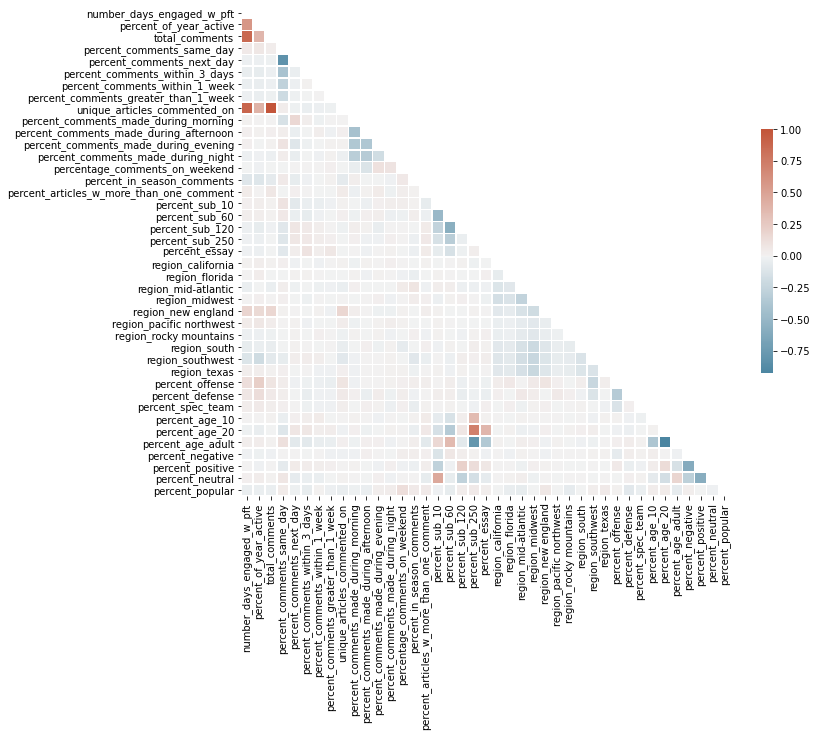

In [8]:
# Draw the heatmap with the mask and correct aspect ratio
corr = features_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [9]:
# Scale features
scaler = MinMaxScaler(feature_range=[0, 1])
# scaler = RobustScaler()
# scaler = StandardScaler()
df_rescaled = scaler.fit_transform(features_df)

In [11]:
year = 2020

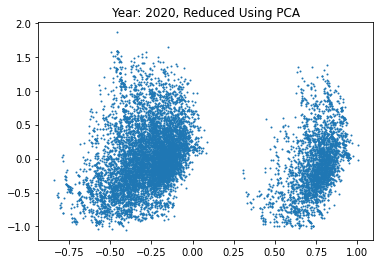

In [12]:
# Reduce dimensionality (using PCA)
pca = PCA(n_components=2, random_state=42)
commentors_pca = pca.fit_transform(df_rescaled)

# Visualize 2-dimensional data
plt.scatter(commentors_pca[:, 0], commentors_pca[:, 1], s=1)
plt.title(f'Year: {year}, Reduced Using PCA')
plt.show()

In [ ]:
# Reduce dimensionality (using TSNE)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(df_rescaled)

# Visualize 2-dimensional data
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1)
plt.title(f'Year: {year}, Reduced Using PCA')
plt.show()

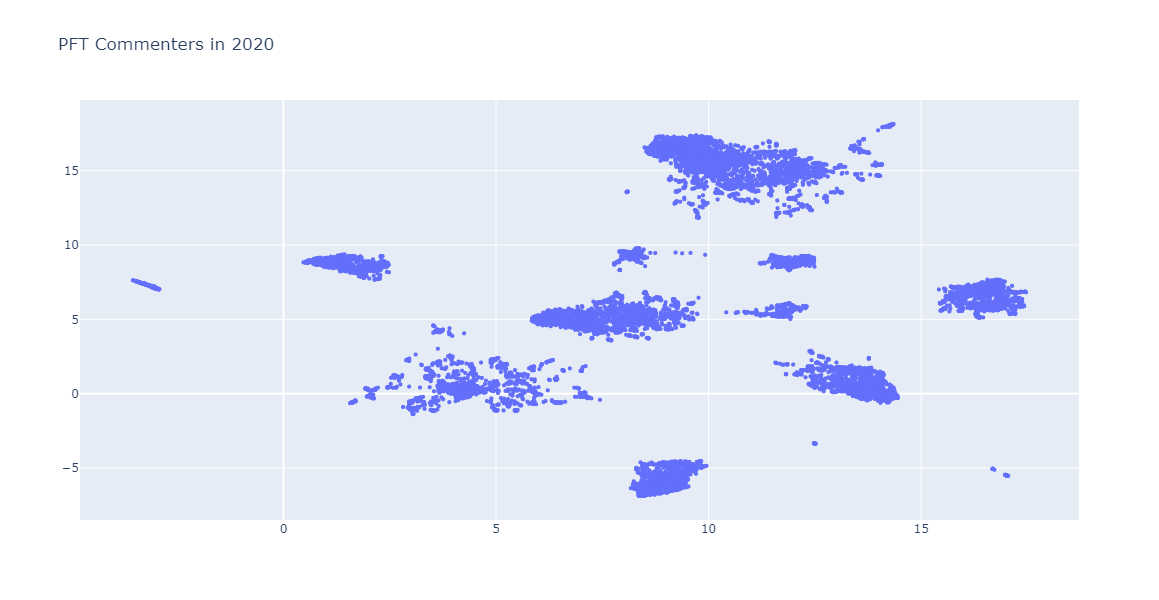

In [13]:
# Reduce dimensionality (using UMAP)
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, metric='euclidean')
embedding = reducer.fit_transform(df_rescaled)

# Visualize 2-dimensional data
fig = go.Figure(data=go.Scatter(x=embedding[:, 0], y=embedding[:, 1], mode='markers', marker=dict(size=4)))
fig.update_layout(title=f'PFT Commenters in {year}')
fig.update_layout(height=600, width=600)
fig.show()

### Cluster data using DBSCAN

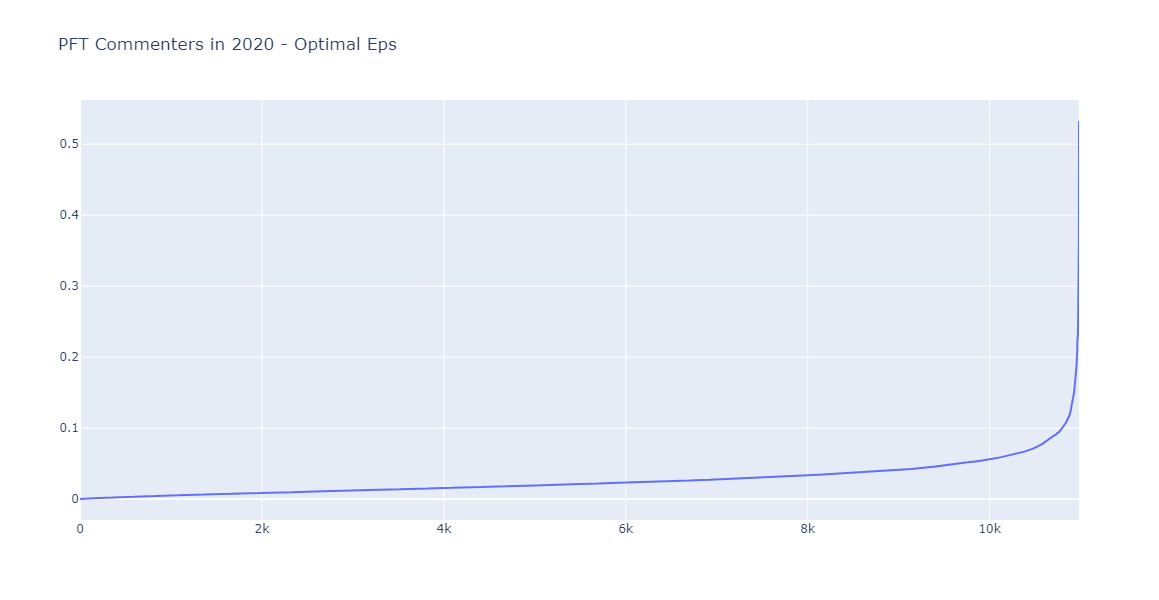

In [14]:
# Check for an optimal eps value
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
fig = go.Figure(data=go.Scatter(y=distances[:,1], mode='lines', marker=dict(size=5)))
fig.update_layout(title='PFT Commenters in 2020 - Optimal Eps')
fig.update_layout(height=600, width=600)
fig.show()

In [15]:
# Cluster
model = DBSCAN(eps=0.8, min_samples=250, n_jobs=-1)
yhat = model.fit_predict(embedding)
clusters = np.unique(yhat)
print('Clustering Complete')
clusters

Clustering Complete


array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

In [16]:
# Combine DR'ed and cluster assignments
embedding_df = pd.DataFrame(embedding)
embedding_df.columns = [0, 1]
embedding_df['cluster'] = yhat
cluster_distribution = embedding_df.groupby(['cluster']).size().reset_index()
cluster_distribution.columns = ['cluster','cluster_size']
cluster_distribution

cluster  cluster_size
0       -1          1735
1        0          2597
2        1           928
3        2           688
4        3          1160
5        4           742
6        5          1029
7        6          1685
8        7           419

In [ ]:
# Visualize the distribution of commentors by clusters
fig = go.Figure()
fig.add_trace(go.Bar(x=cluster_distribution.cluster, y=cluster_distribution.cluster_size))
fig.update_layout(height=300, width=500)
fig.show()

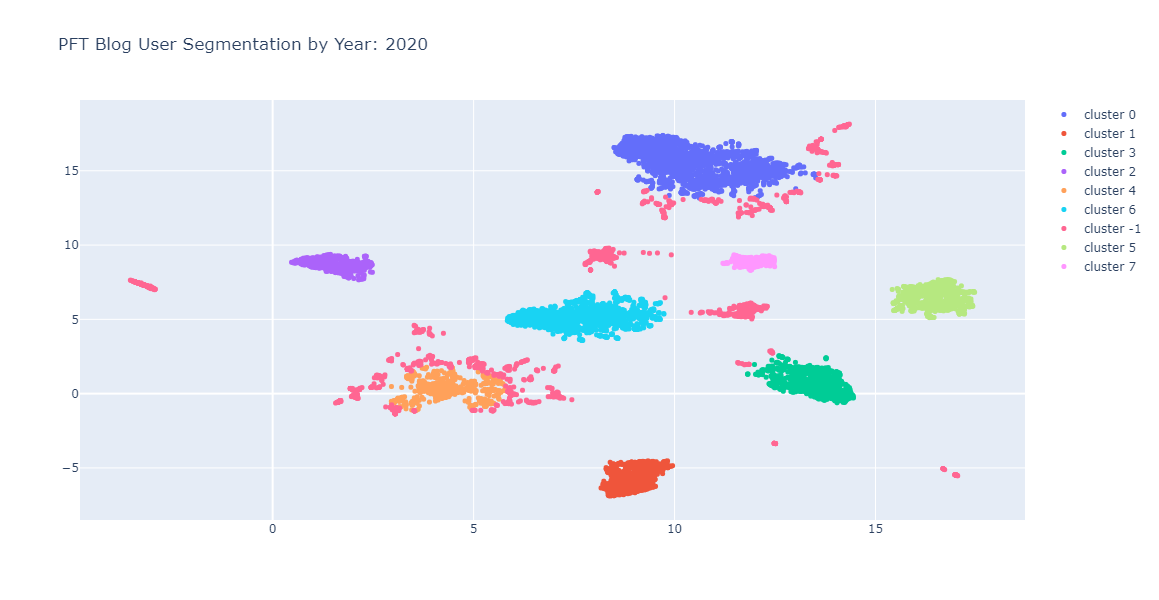

In [17]:
# Visualize clusters
fig = go.Figure()
for c in embedding_df.cluster.unique():
    df_plot = embedding_df[embedding_df.cluster == c]
    fig.add_trace(go.Scatter(x=df_plot[0], y=df_plot[1], name=f'cluster {c}', mode='markers', marker=dict(size=5)))
    
fig.update_layout(height=600, width=600, title_text=f"PFT Blog User Segmentation by Year: {year}")
fig.show()

### Determine dominant features of clusters

In [41]:
model_output_name = f'year_{year}_feature_set_3_0401_0832'

In [42]:
# df_rescaled['cluster'] = yhat
df_rescaled_cluster = pd.DataFrame(df_rescaled, columns=feature_set_one)
df_rescaled_cluster['cluster'] = yhat

# Export 
df_original_cluster = pd.DataFrame(features_df, columns=feature_set_one)
df_original_cluster['cluster'] = yhat
df_original_cluster.to_csv(f"tmp_cluster_model_output/{model_output_name}.csv", header=True, index=False)

avgs = list()
for clust in df_rescaled_cluster.cluster.unique():
    df_rescaled_cluster_single = df_rescaled_cluster[df_rescaled_cluster['cluster'] == clust]
    df_rescaled_cluster_single.drop(labels=['cluster'], axis=1, inplace=True)
    avgs.append(list(df_rescaled_cluster_single.mean()))
    
cluster_avgs = pd.DataFrame(avgs)
cluster_avgs.columns = feature_set_one
cluster_avgs

number_days_engaged_w_pft  percent_of_year_active  total_comments  \
0                   0.040685                0.328126        0.012561   
1                   0.084128                0.458284        0.032094   
2                   0.042174                0.314955        0.012255   
3                   0.038360                0.311076        0.012108   
4                   0.018062                0.183685        0.005533   
5                   0.028468                0.273009        0.008072   
6                   0.011345                0.097252        0.003476   
7                   0.022072                0.248060        0.006135   
8                   0.037430                0.354260        0.010308   

   percent_comments_same_day  percent_comments_next_day  \
0                   0.853870                   0.118021   
1                   0.865194                   0.103772   
2                   0.865776                   0.104310   
3                   0.880233                   0.094041   
4                   0.801213                   0.154447   
5                   0.874065                   0.095015   
6                   0.839712                   0.100980   
7                   0.857337                   0.108552   
8                   0.860621                   0.108592   

   percent_comments_within_3_days  percent_comments_within_1_week  \
0                        0.015672                        0.008625   
1                        0.015733                        0.011099   
2                        0.019914                        0.007328   
3                        0.017587                        0.002907   
4                        0.032749                        0.008895   
5                        0.018635                        0.005875   
6                        0.029049                        0.019827   
7                        0.019534                        0.008844   
8                        0.017184                        0.009547   

   percent_comments_greater_than_1_week  unique_articles_commented_on  \
0                              0.002657                      0.013537   
1                              0.001940                      0.033428   
2                              0.002069                      0.013428   
3                              0.003779                      0.013121   
4                              0.001617                      0.006131   
5                              0.004570                      0.008831   
6                              0.009914                      0.003819   
7                              0.004762                      0.006775   
8                              0.003103                      0.011236   

   percent_comments_made_during_morning  \
0                              0.294301   
1                              0.320474   
2                              0.271897   
3                              0.254797   
4                              0.362129   
5                              0.297626   
6                              0.220288   
7                              0.274733   
8                              0.297852   

   percent_comments_made_during_afternoon  \
0                                0.296457   
1                                0.335991   
2                                0.331207   
3                                0.350872   
4                                0.334232   
5                                0.326113   
6                                0.387550   
7                                0.351118   
8                                0.318138   

   percent_comments_made_during_evening  percent_comments_made_during_night  \
0                              0.239122                            0.163958   
1                              0.201509                            0.136961   
2                              0.224483                            0.165517   
3                              0.217297                            0.16

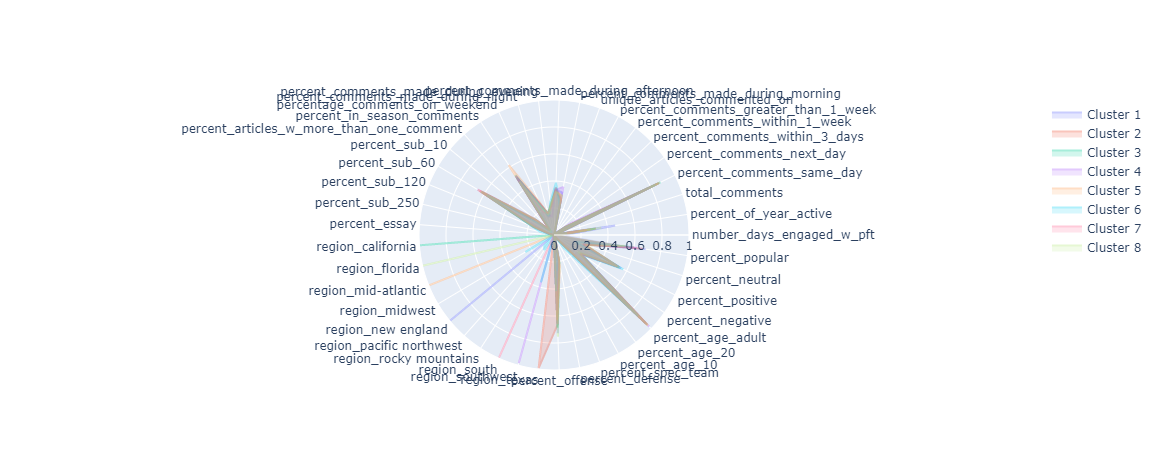

In [43]:
categories = cluster_avgs.columns

fig = go.Figure()
for row in range(1, cluster_avgs.shape[0]):
    fig.add_trace(go.Scatterpolar(
      r=cluster_avgs.iloc[row, :].values,
      theta=categories,
      fill='toself',
      name=f'Cluster {row}',
      opacity=.35
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True)),
    showlegend=True)

fig.show()

### Use XGB to determine feaure importance

In [44]:
# Load data
cluster_df = pd.read_csv(f"tmp_cluster_model_output/{model_output_name}.csv", header=0)
cluster_df.head()

number_days_engaged_w_pft  percent_of_year_active  total_comments  \
0                         92                0.551495             234   
1                          9                0.036545              39   
2                          1                0.000000               1   
3                         13                0.548173              14   
4                          4                0.823920               5   

   percent_comments_same_day  percent_comments_next_day  \
0                        0.8                        0.2   
1                        1.0                        0.0   
2                        1.0                        0.0   
3                        0.8                        0.1   
4                        1.0                        0.0   

   percent_comments_within_3_days  percent_comments_within_1_week  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.1                             0.0   
4                             0.0                             0.0   

   percent_comments_greater_than_1_week  unique_articles_commented_on  \
0                                   0.0                           205   
1                                   0.0                            35   
2                                   0.0                             1   
3                                   0.0                            14   
4                                   0.0                             5   

   percent_comments_made_during_morning  \
0                                   0.2   
1                                   0.6   
2                                   0.0   
3                                   0.1   
4                                   0.4   

   percent_comments_made_during_afternoon  \
0                                     0.5   
1                                     0.3   
2                                     1.0   
3                                     0.3   
4                                     0.4   

   percent_comments_made_during_evening  percent_comments_made_during_night  \
0                                   0.2                                 0.1   
1                                   0.0                                 0.1   
2                                   0.0                                 0.0   
3                                   0.5                                 0.1   
4                                   0.0                                 0.2   

   percentage_comments_on_weekend  percent_in_season_comments  \
0                        0.435897                    0.029915   
1                        0.000000                    0.000000   
2                        0.000000                    0.000000   
3                        0.000000                    0.357143   
4                        0.200000                    1.000000   

   percent_articles_w_more_than_one_comment  percent_sub_10  percent_sub_60  \
0                                  0.107317            0.03            0.69   
1                                  0.114286            0.08            0.26   
2                                  0.000000            0.00            1.00   
3                                  0.000000            0.36            0.50   
4                                  0.000000            0.00            0.20   

   percent_sub_120  percent_sub_250  percent_essay  region_california  \
0             0.26             0.01           0.00                0.0   
1             0.33             0.28           0.05                0.0   
2             0.00             0.00           0.00                0.0   
3             0.14             0.00           0.00                0.0   
4             0.40             0.40           0.00                1.0   

   region_florida  region_mid-atlantic  region_midw

[20:41:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


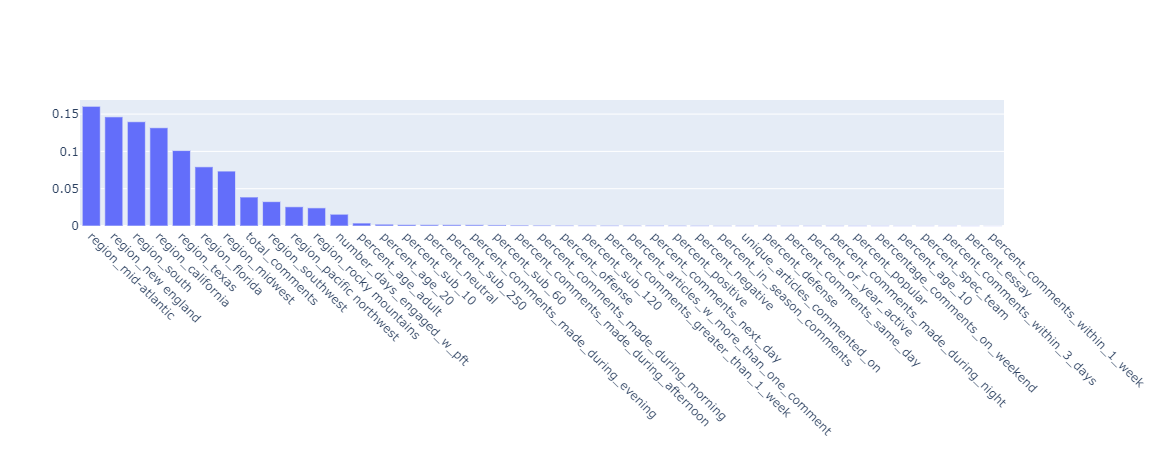

In [45]:
# Fit XGBclassifier on labelled data
X = cluster_df.iloc[:,:-1]
y = cluster_df.iloc[:,-1]
model = XGBClassifier(random_state=42, n_jobs=-1)
model.fit(X, y)

# Create feature importance df
feature_importance_df = pd.DataFrame([cluster_df.columns[:-1], model.feature_importances_])
feature_importance_df = feature_importance_df.T
feature_importance_df.columns = ['feature','importance_score']
feature_importance_df.sort_values(by=['importance_score'], ascending=False, inplace=True)

fig = go.Figure()
fig.add_trace(go.Bar(x=feature_importance_df['feature'], y=feature_importance_df['importance_score']))
fig.update_xaxes(tickangle = 45)
# fig.update_layout(height=300, width=500)
fig.show()